Import all modules we will use for this notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.preprocessing import scale
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve, precision_recall_curve

# The below suppresses all warnings in the notebook
# Only leave this uncommented for display purposes
import warnings
warnings.filterwarnings("ignore")

Load the data into memory

In [2]:
df = pd.read_csv('winequality-white.csv', sep=';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


Now replace any quality rating less than or equal to 5 with bad (represented by 0) and any rating greater than 5 with good (represented by 1).

In [3]:
mask = df.quality <= 5
df.loc[mask, 'quality'] = 0
df.loc[~mask, 'quality'] = 1

df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1


Get statistical descriptions of all variables in the dataset.

In [4]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,0.665169
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.471979
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,0.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,0.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,1.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,1.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,1.000000


Create pair plots using Seaborn to identify redundant features using correlation and covariance.

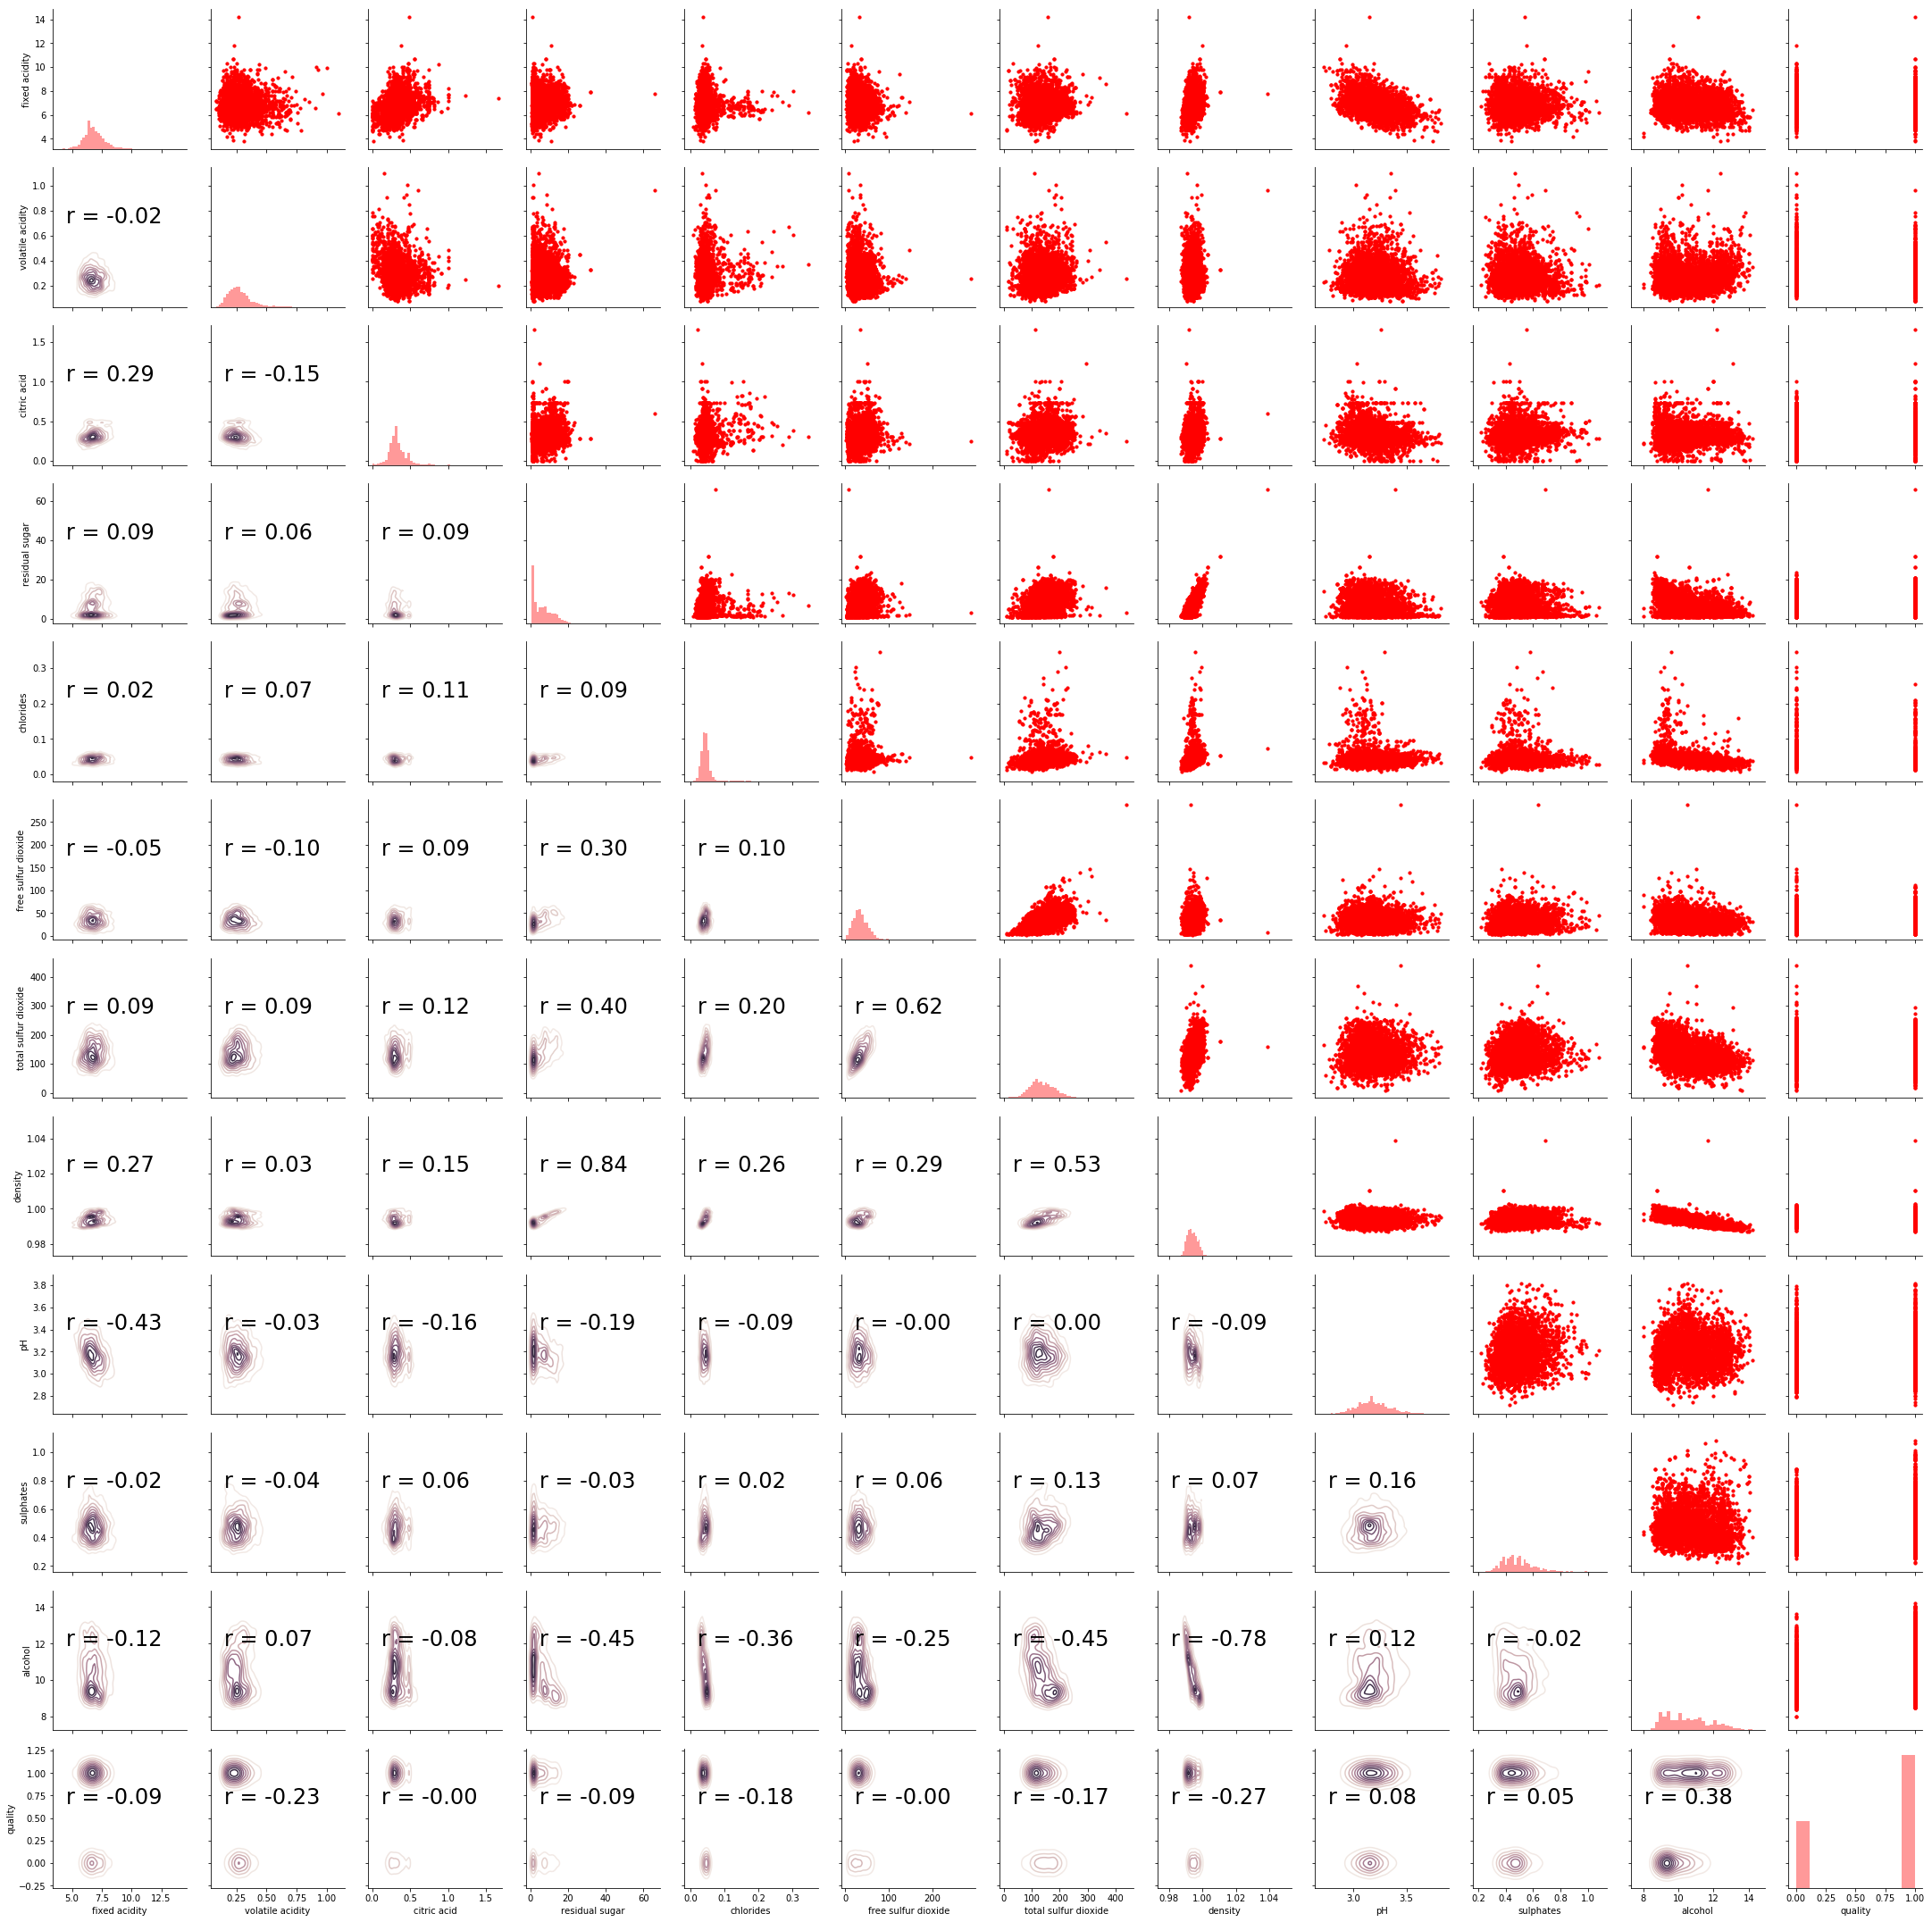

In [5]:
# Calculate correlation coefficient
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r), xy=(.1, .6), xycoords=ax.transAxes, size = 24)
    
cmap = sns.cubehelix_palette(light=1, dark = 0.1, hue = 0.5, as_cmap=True)

sns.set_context(font_scale=2)

# Pair grid set up
g = sns.PairGrid(df)

# Scatter plot on the upper triangle
g.map_upper(plt.scatter, s=10, color = 'red')

# Distribution on the diagonal
g.map_diag(sns.distplot, kde=False, color = 'red')

# Density Plot and Correlation coefficients on the lower triangle
g.map_lower(sns.kdeplot, cmap = cmap)
g.map_lower(corrfunc);

From the above we noted the following relationships.<br>
Density seems to correlate quite well with many of the others (Will remove density)<br>
Total Sulfur Dioxide and Free Sulfur Dioxide correlate with each other (will remove Free Sulfur Dioxide)<br>
Alcohol Correlates with residual sugar (will remove Alcohol)<br>
pH correlates well with fixed acidity (will remove fixed acidity)<br>
Residual Sugar Correlates well with Total Sufur Dioxide (Will remove total sulfur dioxide)<br>

We thus remove those features from our model.

In [6]:
df = df.drop(columns=['density','free sulfur dioxide','alcohol','fixed acidity','total sulfur dioxide'])

After removing recreate the pair plots to ensure no others need to be removed

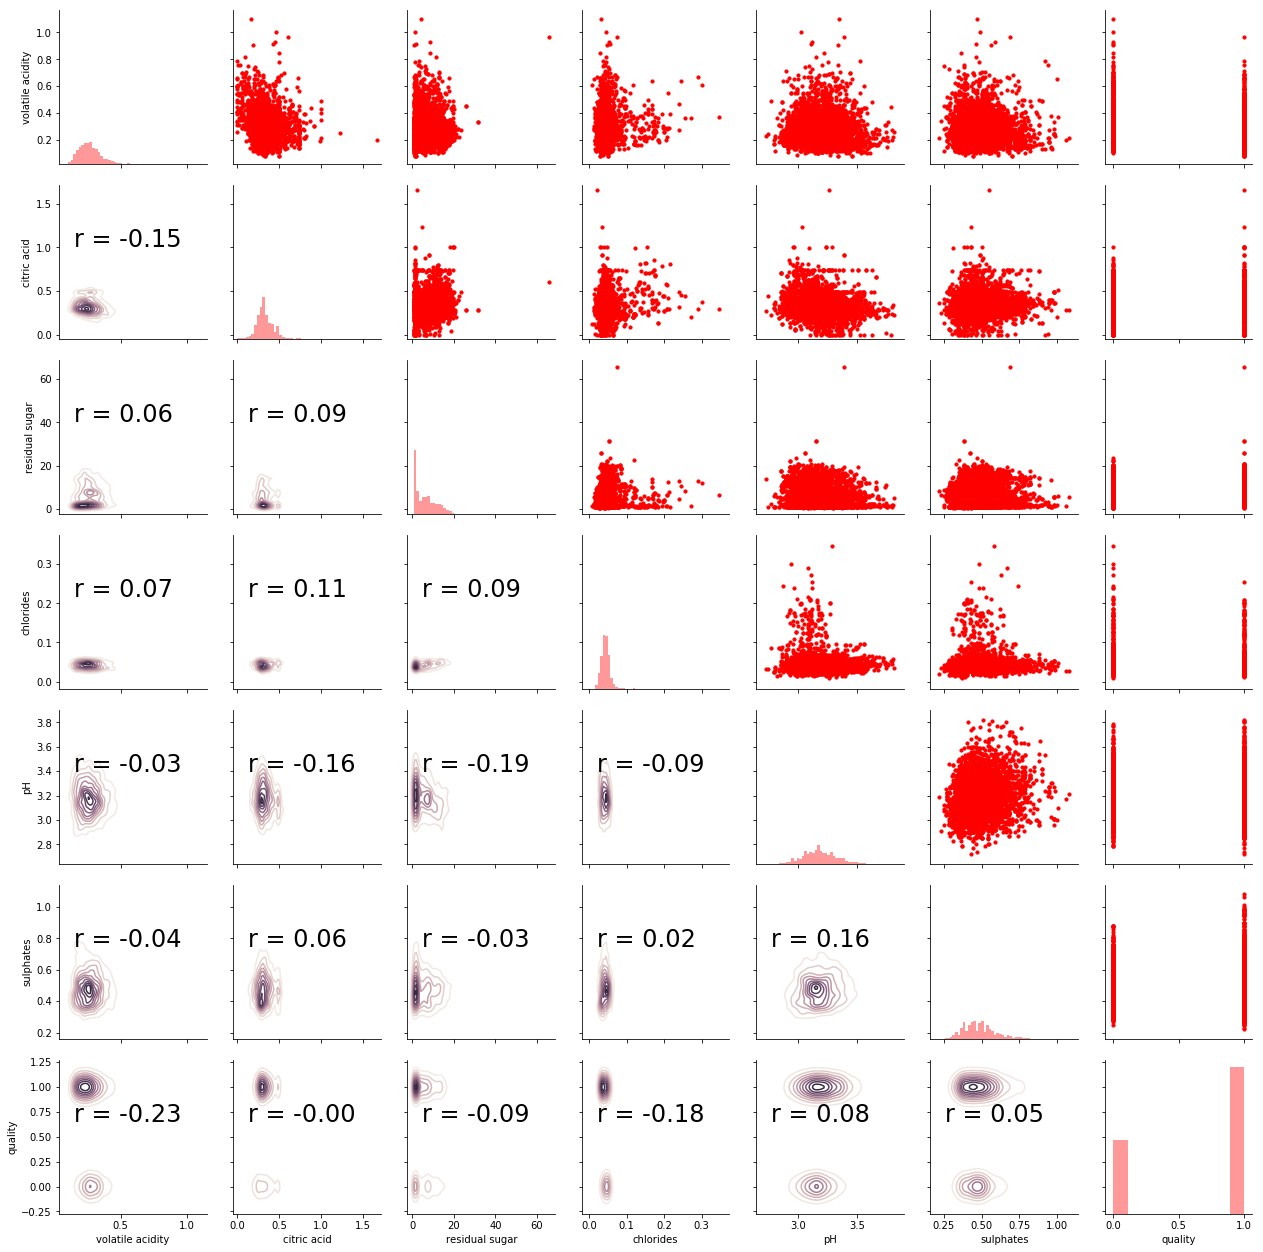

In [7]:
sns.set_context(font_scale=2)

# Pair grid set up
g = sns.PairGrid(df)

# Scatter plot on the upper triangle
g.map_upper(plt.scatter, s=10, color = 'red')

# Distribution on the diagonal
g.map_diag(sns.distplot, kde=False, color = 'red')

# Density Plot and Correlation coefficients on the lower triangle
g.map_lower(sns.kdeplot, cmap = cmap)
g.map_lower(corrfunc);

I will thus choose to keep the following variables in my model:<br>
volatile acidity<br>
citric acid<br>
residual sugar<br>
chlorides<br>
pH<br>
sulphates<br>

Now separate the data into a feature matrix and a target matrix (quality).

In [8]:
# Target Vector
y = df["quality"]
# Note that in order for KNeighborsClassifier to work correctly the target vector cannot be float
y = y.values.astype(np.int)

#Rest of data goes into feature matrix
X = df.drop(columns='quality') # Remove quality
X = X.values

print(X.shape)
print(y.shape)

(4898, 6)
(4898,)


We now partition the data into training and testing portions

In [9]:
# Create training and testing datasets
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(3918, 6)
(980, 6)
(3918,)
(980,)


We now standardize our feature matrices using an sklearn scaler.

In [10]:
X_train = scale(X_train)
X_test = scale(X_test)

Now use GridSearchCV to choose best model based on hyperparamters

In [11]:
param_grid = {'n_neighbors': [1, 3, 5, 7, 9, 15, 21, 23, 33, 35, 37], 'p': [1, 2, 10, 100], 'weights': ["uniform", "distance"]}

knn = KNeighborsClassifier()

knn_cv = GridSearchCV(knn, param_grid, scoring='f1', cv=10)
knn_cv.fit(X_train, Y_train)

print("Best Score: %f" % knn_cv.best_score_)
print("Optimal Hyperparameter Values: ", knn_cv.best_params_)

Best Score: 0.869013
Optimal Hyperparameter Values:  {'n_neighbors': 21, 'p': 1, 'weights': 'distance'}


Using best hyperparameter values found above we now fit our training data.

In [12]:
optimal_neighbors = 21
optimal_p = 1

knn = KNeighborsClassifier(weights="uniform", algorithm='auto', n_neighbors=optimal_neighbors, p=optimal_p)
knn.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=21, p=1,
           weights='uniform')

Now evaluate the model's performance using cross-validation on the training set.

In [13]:
scores = cross_val_score(knn, X_train, Y_train, scoring='f1', cv=3)
print(scores)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[0.82419855 0.81611023 0.830721  ]
Accuracy: 0.82 (+/- 0.01)


Now create the y_train_prediction vector

In [14]:
Y_train_pred = cross_val_predict(knn, X_train, Y_train, cv=3)

print(len(Y_train_pred))

3918


We now evaluate how well our prediction is for the training set.<br>
To do this we calculate the precision, recall, and F1 score for the predictions.

In [15]:
print('All below are for the training dataset:')
# The precision is intuitively the ability of the classifier not to label as positive
# a sample that is negative.
# The precision is the ratio tp / (tp + fp) where tp is the number of true positives
# and fp the number of false positives
precision = precision_score(Y_train, Y_train_pred) 
print("Precision = %f" % precision)

# The recall is intuitively the ability of the classifier to find all the positive samples
# The recall is the ratio tp / (tp + fn) where tp is the number of true
# positives and fn the number of false negatives
recall = recall_score(Y_train, Y_train_pred)
print("Recall = %f" % recall)

# The F1 score can be interpreted as a weighted average of the precision and recall
# Calculated as 2 * (precision * recall) / (precision + recall)
f1 = f1_score(Y_train, Y_train_pred)
print("F1 Score = %f" % f1)

print('The confusion matrix for the training dataset is below:')
confusion_matrix(Y_train, Y_train_pred)

All below are for the training dataset:
Precision = 0.761444
Recall = 0.897076
F1 Score = 0.823714
The confusion matrix for the training dataset is below:


array([[ 545,  740],
       [ 271, 2362]])

We now calculate the False Positive Rate (FPR), True Positive Rate (TPR), and Thresholds Checked for use in creating the ROC curve and Precision-Recall Curve.

In [16]:
# Get the 2nd column of the matrix of predicted probabilities for each data point
# The 2nd column stores the probalities of the positive class
Y_scores = cross_val_predict(knn, X_train, Y_train, method="predict_proba", cv=3)[:, 1]

# TPR is true positive rate
# FPR is false positive rate
# The ROC is also known as a relative operating characteristic curve, because it is a
# comparison of two operating characteristics (TPR and FPR) as the criterion changes
fpr, tpr, thresholds = roc_curve(Y_train, Y_scores)

print("\nFPR FPR & TPR for Various Threshold Values:")

print("FPR: ", fpr)
print("TPR: ", tpr)
# These are the four conditions considered for separating into classes
print("\nThresholds: ", thresholds)
print('Below')
print(Y_scores)


FPR FPR & TPR for Various Threshold Values:
FPR:  [0.         0.00311284 0.02101167 0.05136187 0.11050584 0.18365759
 0.24513619 0.31284047 0.37976654 0.44669261 0.51906615 0.57587549
 0.6459144  0.71984436 0.78754864 0.85291829 0.91284047 0.95719844
 0.98210117 0.99766537 0.99922179 1.        ]
TPR:  [0.         0.04557539 0.1272313  0.22255982 0.36232434 0.48423851
 0.59969616 0.69502469 0.75996962 0.8135207  0.8579567  0.89707558
 0.92859856 0.94986707 0.96657805 0.98214964 0.99164451 0.99544246
 0.99848082 0.99924041 1.         1.        ]

Thresholds:  [2.         1.         0.95238095 0.9047619  0.85714286 0.80952381
 0.76190476 0.71428571 0.66666667 0.61904762 0.57142857 0.52380952
 0.47619048 0.42857143 0.38095238 0.33333333 0.28571429 0.23809524
 0.19047619 0.14285714 0.0952381  0.04761905]
Below
[0.71428571 0.9047619  0.95238095 ... 0.57142857 0.76190476 0.66666667]


Now plot the ROC curve.<br>
Note that points above the dashed line represent predictions above chance.

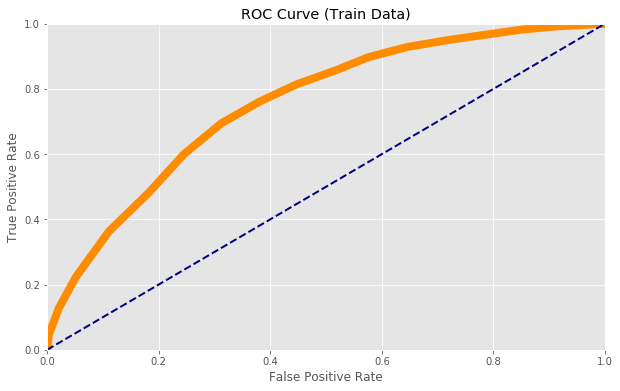

The area under the curve is: 0.7518700835401024


In [17]:
plt.style.use('ggplot')

fig = plt.figure(figsize=(10, 6))
def plot_roc_curve(fpr, tpr, label=None): 
    plt.plot(fpr, tpr, color='darkorange', linewidth=8, label=label) 
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.axis([0, 1, 0, 1])
    plt.title('ROC Curve (Train Data)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()

# Area under ROC curve
from sklearn.metrics import roc_auc_score
area_curve = roc_auc_score(Y_train,Y_scores)

print('The area under the curve is:', area_curve)

Now create the Precision-Recall curve for our model.

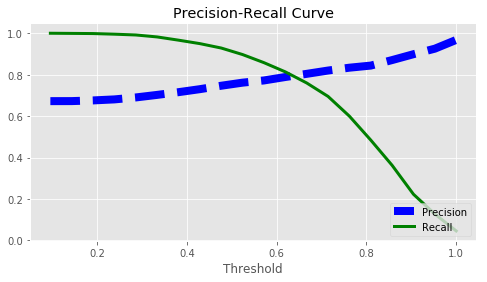

In [18]:
plt.style.use('ggplot')

Y_scores = cross_val_predict(knn, X_train, Y_train, method="predict_proba", cv=3)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(Y_train, Y_scores)

fig = plt.figure(figsize=(8, 4))
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds): 
    plt.plot(thresholds, precisions[:-1], "b--",  linewidth=8, label="Precision") 
    plt.plot(thresholds, recalls[:-1], "g-",  linewidth=3, label="Recall") 
    plt.xlabel("Threshold")
    plt.legend(loc="lower right")
    plt.title('Precision-Recall Curve')

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

To determine the optimal threshold from a Precision-Recall Curve we often want to balance the precision and the recall.<br>
I will thus choose to set the threshold to about 0.65 for the following steps.

We now use this chosen threshold to see what our error metrics are for the training set.

In [19]:
print('The below are the performance measures using only the training dataset:')

thresh = 0.65 # Chosen optimal threshold 

Y_train_predicted = (knn.predict_proba(X_train)[:,1] >= thresh).astype(bool)

precision = precision_score(Y_train, Y_train_predicted) 
print("\nPrecision (Threshold %.2f) = %f" % (thresh, precision))

recall = recall_score(Y_train, Y_train_predicted)
print("Recall (Threshold %.2f) = %f" % (thresh, recall))

f1 = f1_score(Y_train, Y_train_predicted)
print("F1 Score = (Threshold %.2f) = %f" % (thresh, f1))


print("Confusion Matrix (Threshold %.2f)" %  thresh) 
print(confusion_matrix(Y_train, Y_train_predicted))

# Below calculates the accuracy with the chosen threshold
scores = cross_val_score(knn, X_train, Y_train, scoring='f1', cv=3)
print('The average accuracy is:',np.mean(scores))

The below are the performance measures using only the training dataset:

Precision (Threshold 0.65) = 0.829710
Recall (Threshold 0.65) = 0.782757
F1 Score = (Threshold 0.65) = 0.805550
Confusion Matrix (Threshold 0.65)
[[ 862  423]
 [ 572 2061]]
The average accuracy is: 0.8236765944110337


We now see how well the model performs on our test data.<br>
The same error metrics as were used above to evaluate the training data are used again.

In [20]:
print('The below are the performance measures using the testing dataset:')

thresh = 0.65 # Chosen optimal threshold 

Y_test_predicted = (knn.predict_proba(X_test)[:,1] >= thresh).astype(bool)

precision = precision_score(Y_test, Y_test_predicted) 
print("\nPrecision (Threshold %.2f) = %f" % (thresh, precision))

recall = recall_score(Y_test, Y_test_predicted)
print("Recall (Threshold %.2f) = %f" % (thresh, recall))

f1 = f1_score(Y_test, Y_test_predicted)
print("F1 Score = (Threshold %.2f) = %f" % (thresh, f1))


print("Confusion Matrix (Threshold %.2f)" %  thresh) 
print(confusion_matrix(Y_test, Y_test_predicted))

# Below calculates the accuracy with the chosen threshold
scores = cross_val_score(knn, X_test, Y_test, scoring='f1', cv=3)
print('The average accuracy is:',np.mean(scores))

The below are the performance measures using the testing dataset:

Precision (Threshold 0.65) = 0.771987
Recall (Threshold 0.65) = 0.758400
F1 Score = (Threshold 0.65) = 0.765133
Confusion Matrix (Threshold 0.65)
[[215 140]
 [151 474]]
The average accuracy is: 0.779236997898777


Note that, as would be expected, the accuracy is lower than it would have been testing only against the training dataset, but that we do not see evidence of extreme overfitting.<br>
It seems to work reasonably well.